##Breast Cancer Image Classification using CNN



Dataset tersebut merupakan gambar mikroskopis dengan zoom sebesar 400x pada pasien yang mengalami kanker payudara (Breast Cancer), dimana pada dataset tesebut dibagi menjadi dua kelas yaitu Tumor ganas (Malignant) dan Tumor jinak (Benign). Dataset sudah dibagi menjadi folder training dan testing yang berbeda dengan struktur sebagai berikut:
- BreaKHis 400X/train/benign/*kumpulan gambar
- BreaKHis 400X/train/malignant/*kumpulan gambar
- BreaKHis 400X/test/benign/*kumpulan gambar
- BreaKHis 400X/test/malignant/*kumpulan gambar



---



## Download dan Load Data

In [ ]:
from google.colab import drive
from google.colab import files

# Library

from google.colab import drive

# U/ mengorganisir dataset pada folder
import os
import glob
import zipfile
import shutil
import cv2 
import numpy as np
import random

# U/ pemodelan 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten,Input, Dropout
from tensorflow.keras.layers import GlobalMaxPool2D, AvgPool2D, GlobalAvgPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import Model

# U/ visualisasi plot dan report
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings( 'ignore')

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Mengatur Directory Konfigurasi
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Dataset/Kaggle"

In [ ]:
# Masuk Direktori
%cd /content/gdrive/My Drive/Dataset/Kaggle

/content/gdrive/My Drive/Dataset/Kaggle


In [ ]:
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download -d forderation/breakhis-400x

100% 803M/803M [00:11<00:00, 62.3MB/s]
100% 803M/803M [00:11<00:00, 72.5MB/s]


In [ ]:
# ekstrak dataset 
ekstrak_zip = '/content/gdrive/My Drive/Dataset/Kaggle/breakhis-400x.zip'
out_zip = zipfile.ZipFile(ekstrak_zip, 'r')
out_zip.extractall('/content/gdrive/My Drive/Dataset/Modul 2')
out_zip.close()

print('Selesai Ekstrak')

Selesai Ekstrak


In [ ]:
train_benign_dir = "/content/gdrive/My Drive/Dataset/Modul 2/BreaKHis 400X/train/benign/"
train_malignant_dir = "/content/gdrive/My Drive/Dataset/Modul 2/BreaKHis 400X/train/malignant/"
test_benign_dir = "/content/gdrive/My Drive/Dataset/Modul 2/BreaKHis 400X/test/benign/"
test_malignant_dir = "/content/gdrive/My Drive/Dataset/Modul 2/BreaKHis 400X/test/malignant/"

print('total training benign images :', len(os.listdir(train_benign_dir)))
print('total training malignant images:', len(os.listdir(train_malignant_dir)))
print('total test benign images:', len(os.listdir(test_benign_dir)))
print('total test malignant images:', len(os.listdir(test_malignant_dir)))

total training benign images : 371
total training malignant images: 777
total test benign images: 176
total test malignant images: 369


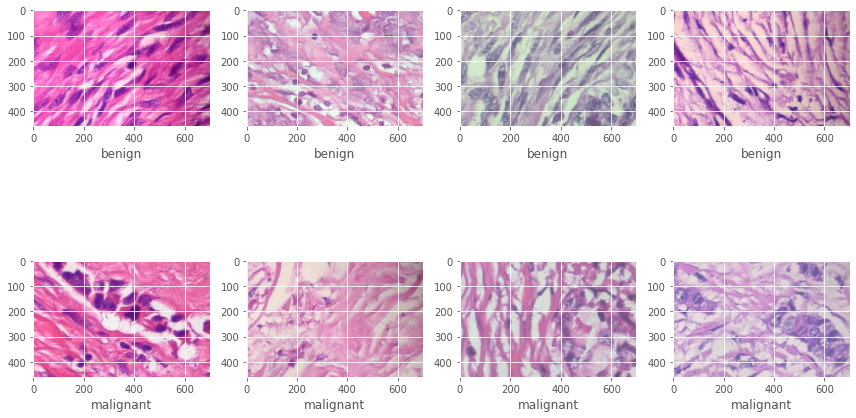

In [ ]:
# pengaturan letak folder / dir
benign_dir = os.path.join(train_benign_dir, test_benign_dir)  
malignant_dir = os.path.join(train_malignant_dir, test_malignant_dir)

list1 = [benign_dir,malignant_dir]

fig = plt.figure(figsize=(12, 8))
plt.style.use("ggplot")

j=1
for i in list1: 
    for k in range(4):
        filenames  = os.listdir(i)
        sample = random.choice(filenames)
        image = load_img(i+sample)
        plt.subplot(2,4,j)
        plt.imshow(image)
        plt.xlabel(i.split("/")[-2])
        j+=1
plt.tight_layout()

## Preprocessing Data

In [ ]:
# Gather data train dg image 250x250
training_dir = os.path.join('/content/gdrive/My Drive/Dataset/Modul 2/BreaKHis 400X/train')

train_data = []
train_label = []
for r, d, f in os.walk(training_dir):
    for file in f:
        if ".png" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (250,250))
            train_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)

train_data = np.array(train_data)
train_label = np.array(train_label)

print('Selesai Gather Data Train')

Selesai Gather Data Train


In [ ]:
# Gather data validation dg image 250x250
validation_dir = os.path.join('/content/gdrive/My Drive/Dataset/Modul 2/BreaKHis 400X/test')

val_data = []
val_label = []
for r, d, f in os.walk(validation_dir):
    for file in f:
        if ".png" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (250,250))
            val_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            val_label.append(label)

val_data = np.array(val_data)
val_label = np.array(val_label)

print('Selesai Gather Data Validation')

Selesai Gather Data Validation


In [ ]:
print("Train Data = ", train_data.shape)
print("Train Label = ", train_label.shape)
print("Validation Data = ", val_data.shape)
print("Validation Label = ", val_label.shape)

Train Data =  (1148, 250, 250, 3)
Train Label =  (1148,)
Validation Data =  (545, 250, 250, 3)
Validation Label =  (545,)


In [ ]:
# Normalisasi data
print("Data sebelum di-normalisasi ", train_data[0][0][0])
x_train = train_data.astype('float32') / 255.0
x_val = val_data.astype('float32') / 255.0
print("Data setelah di-normalisasi ", x_train[0][0][0])

Data sebelum di-normalisasi  [192 190 189]
Data setelah di-normalisasi  [0.7529412  0.74509805 0.7411765 ]


In [ ]:
print("Label sebelum di-encoder [0]", train_label[100:105])
print("Label sebelum di-encoder [1]", train_label[995:1000])

lb = LabelEncoder()
y_train = lb.fit_transform(train_label)
y_val = lb.fit_transform(val_label)

print("\nLabel setelah di-encoder [0]", y_train[100:105])
print("Label setelah di-encoder [1]", y_train[995:1000])

Label sebelum di-encoder [0] ['benign' 'benign' 'benign' 'benign' 'benign']
Label sebelum di-encoder [1] ['malignant' 'malignant' 'malignant' 'malignant' 'malignant']

Label setelah di-encoder [0] [0 0 0 0 0]
Label setelah di-encoder [1] [1 1 1 1 1]


#Modelling Model 1 (Global Maxpool) dan Model 2 (AveragePool) 

In [ ]:
# Model Scenario Pertama

model_1 =  Sequential([
    # Input Layer
    Input(shape=(250,250, 3)),

    # Convolutional layer
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    GlobalMaxPool2D(),

    # Meratakan input menjadi 1 dimensi
    Flatten(),
    
    #Fully-connected layer
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_1.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_137 (Conv2D)          (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 29, 29, 128)       0         
_________________________________________________________________
global_max_pooling2d_20 (Glo (None, 128)             

In [ ]:
# Model Scenario Kedua

model_2 =  Sequential([
    # Input Layer
    Input(shape=(250,250, 3)),

    # CNN Model 
    Conv2D(32, (3,3), activation='relu'),
    AvgPool2D(pool_size=(2, 2)),
    Conv2D(64, (3,3), activation='relu'),
    AvgPool2D(pool_size=(2, 2)),
    Conv2D(128, (3,3), activation='relu'),
    AvgPool2D(pool_size=(2, 2)),
    GlobalAvgPool2D(),

    # Meratakan input menjadi 1 dimensi
    Flatten(),
    
    #Fully-connected layer
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_2.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 248, 248, 32)      896       
_________________________________________________________________
average_pooling2d_68 (Averag (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 122, 122, 64)      18496     
_________________________________________________________________
average_pooling2d_69 (Averag (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 59, 59, 128)       73856     
_________________________________________________________________
average_pooling2d_70 (Averag (None, 30, 30, 128)       0         
_________________________________________________________________
global_average_pooling2d_18  (None, 128)             

In [ ]:
# Compile dengan optimizer adam
Adam(learning_rate=0.00146, name='Adam')
model_1.compile(optimizer = 'Adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
model_2.compile(optimizer = 'Adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nAkurasi train dan validasi telah mencapai nilai > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
# Training model scenario Pertama
history1 = model_1.fit(x_train, y_train,
                    batch_size=8,
                    steps_per_epoch = len(x_train) // 8,
                    epochs=100,
                    validation_data=(x_val, y_val),
                    callbacks=[callbacks])

Epoch 1/100
143/143 [==============================] - 3s 19ms/step - loss: 0.5527 - accuracy: 0.7238 - val_loss: 0.5457 - val_accuracy: 0.7064
Epoch 2/100
143/143 [==============================] - 2s 17ms/step - loss: 0.4922 - accuracy: 0.7816 - val_loss: 0.4752 - val_accuracy: 0.8092
Epoch 3/100
143/143 [==============================] - 2s 17ms/step - loss: 0.4692 - accuracy: 0.7886 - val_loss: 0.5156 - val_accuracy: 0.7798
Epoch 4/100
143/143 [==============================] - 2s 17ms/step - loss: 0.4405 - accuracy: 0.8211 - val_loss: 0.4779 - val_accuracy: 0.8092
Epoch 5/100
143/143 [==============================] - 2s 17ms/step - loss: 0.4299 - accuracy: 0.8307 - val_loss: 0.4464 - val_accuracy: 0.8349
Epoch 6/100
143/143 [==============================] - 2s 17ms/step - loss: 0.4242 - accuracy: 0.8351 - val_loss: 0.4440 - val_accuracy: 0.8128
Epoch 7/100
143/143 [==============================] - 2s 17ms/step - loss: 0.4139 - accuracy: 0.8307 - val_loss: 0.4093 - val_accuracy:

In [ ]:
# Training model scenario Kedua
history2 = model_2.fit(x_train, y_train,
                    batch_size=8,
                    steps_per_epoch = len(x_train) // 8,
                    epochs=100,
                    validation_data=(x_val, y_val),
                    callbacks=[callbacks])

Epoch 1/100
143/143 [==============================] - 3s 18ms/step - loss: 0.5913 - accuracy: 0.6801 - val_loss: 0.6583 - val_accuracy: 0.6037
Epoch 2/100
143/143 [==============================] - 2s 17ms/step - loss: 0.5234 - accuracy: 0.7272 - val_loss: 0.5728 - val_accuracy: 0.6771
Epoch 3/100
143/143 [==============================] - 2s 17ms/step - loss: 0.4964 - accuracy: 0.7807 - val_loss: 0.4756 - val_accuracy: 0.8349
Epoch 4/100
143/143 [==============================] - 2s 17ms/step - loss: 0.4453 - accuracy: 0.8263 - val_loss: 0.4854 - val_accuracy: 0.8147
Epoch 5/100
143/143 [==============================] - 2s 17ms/step - loss: 0.4773 - accuracy: 0.8000 - val_loss: 0.5293 - val_accuracy: 0.7523
Epoch 6/100
143/143 [==============================] - 2s 17ms/step - loss: 0.4776 - accuracy: 0.7982 - val_loss: 0.4733 - val_accuracy: 0.8183
Epoch 7/100
143/143 [==============================] - 2s 17ms/step - loss: 0.4318 - accuracy: 0.8333 - val_loss: 0.4449 - val_accuracy:

## Plot Accuracy dan Loss Untuk Model 1 dan Model 2

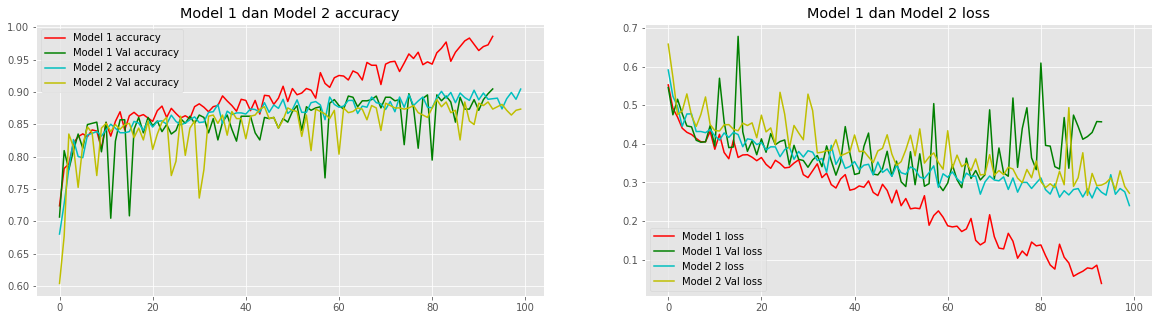

In [ ]:
# Plot Acc dan Loss

acc1 = history1.history["accuracy"]
val_acc1 = history1.history["val_accuracy"]
acc2 = history2.history["accuracy"]
val_acc2 = history2.history["val_accuracy"]

loss1 = history1.history["loss"]
val_loss1 = history1.history["val_loss"]
loss2 = history2.history["loss"]
val_loss2 = history2.history["val_loss"]

# epochs = range(50)
epochs = range(len(acc1))
epochs2 = range(len(acc2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
ax1.plot(epochs, acc1, 'r')
ax1.plot(epochs, val_acc1, 'g')
ax1.plot(epochs2, acc2, 'c')
ax1.plot(epochs2, val_acc2, 'y')
ax1.set_title('Model 1 dan Model 2 accuracy')
ax1.legend(['Model 1 accuracy','Model 1 Val accuracy','Model 2 accuracy','Model 2 Val accuracy'])

ax2.plot(epochs, loss1, 'r')
ax2.plot(epochs, val_loss1, 'g')
ax2.plot(epochs2, loss2, 'c')
ax2.plot(epochs2, val_loss2, 'y')
ax2.set_title('Model 1 dan Model 2 loss')
ax2.legend(['Model 1 loss','Model 1 Val loss','Model 2 loss','Model 2 Val loss'])

plt.show()

## Percobaan Prediksi

Saving SOB_B_A-14-22549AB-400-019.png to SOB_B_A-14-22549AB-400-019.png
Prediksi =  0.0

Model 1, Prediksi Gambar adalah Tumor Jinak (Benign)
Model 2, Prediksi Gambar adalah Tumor Jinak (Benign)


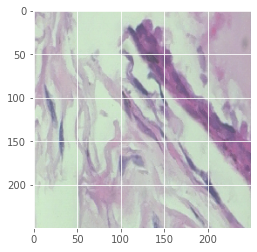

In [ ]:
uploaded1 = files.upload()

for fn in uploaded1.keys():
 
  # Prediksi Gambar
  path = fn
  img = image.load_img(path, target_size=(250,250))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])

  classes = model_1.predict(images, batch_size=8)
  classes2 = model_2.predict(images, batch_size=8)

  print('Prediksi = ',classes[0][0])
  
  # Prediksi Gambar 
  # Benign 0 - <1 / Malignant >1
  if classes[0][0] >= 0 and classes[0][0] < 1:
    print('\nModel 1, Prediksi Gambar adalah Tumor Jinak (Benign)')
  else:
    print('Model 1, Prediksi Gambar adalah Tumor Ganas (Malignant)')

  if classes2[0][0] >= 0 and classes[0][0] < 1:
    print('Model 2, Prediksi Gambar adalah Tumor Jinak (Benign)')
  else:
    print('Model 2, Prediksi Gambar adalah Tumor Ganas (Malignant)')

Saving SOB_M_DC-14-5287-400-011.png to SOB_M_DC-14-5287-400-011.png
Prediksi =  1.0
Model 1, Prediksi Gambar adalah Tumor Ganas (Malignant)
Model 2, Prediksi Gambar adalah Tumor Ganas (Malignant)


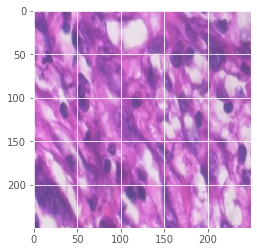

In [ ]:
uploaded2 = files.upload()

for fn in uploaded2.keys():
 
  # Prediksi Gambar
  path = fn
  img = image.load_img(path, target_size=(250,250))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])

  classes = model_1.predict(images, batch_size=8)
  classes2 = model_2.predict(images, batch_size=8)

  print('Prediksi = ',classes[0][0])
  
  # Prediksi Gambar 
  # Benign 0 - <1 / Malignant >1
  if classes[0][0] >= 0 and classes[0][0] < 1:
    print('\nModel 1, Prediksi Gambar adalah Tumor Jinak (Benign)')
  else:
    print('Model 1, Prediksi Gambar adalah Tumor Ganas (Malignant)')

  if classes2[0][0] >= 0 and classes[0][0] < 1:
    print('Model 2, Prediksi Gambar adalah Tumor Jinak (Benign)')
  else:
    print('Model 2, Prediksi Gambar adalah Tumor Ganas (Malignant)')

##Classification Report dan Accuracy

In [ ]:
print("model 1")
pred = model_1.predict(x_val)
labels = (pred > 0.5).astype(np.int)

print(classification_report(y_val, labels))

print("model 2")
pred2 = model_2.predict(x_val)
labels2 = (pred2 > 0.5).astype(np.int)

print(classification_report(y_val, labels2))

model 1
              precision    recall  f1-score   support

           0       0.88      0.81      0.85       176
           1       0.91      0.95      0.93       369

    accuracy                           0.90       545
   macro avg       0.90      0.88      0.89       545
weighted avg       0.90      0.90      0.90       545

model 2
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       176
           1       0.90      0.91      0.91       369

    accuracy                           0.87       545
   macro avg       0.86      0.85      0.85       545
weighted avg       0.87      0.87      0.87       545

